# Process Price Data
Price data is saved as Data\PriceData.csv
In this module I will process the price data.

In [1]:
#Import all the required librararies
import numpy as np
import pandas as pd
import os.path
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import cm

from matplotlib.dates import DateFormatter
import matplotlib.dates  as mdates
from sklearn.ensemble import RandomForestClassifier
import re
%matplotlib inline

## Check if ASX file is present

ASXList static is saved as Data\\ASXList.csv 
This file is used as reference for selected ASX companies details.
The file contains listing date, GICs industry group and market cap of a Company.

Check if input file Data\\ASXList.csv exists.
Set boolExit flag to True if the file does not exit
The rest of operations will not run if the file is not present

In [2]:
boolExit = False
if not os.path.isfile(os.path.abspath('Data\\ASXList.csv')):
    print("Data\\ASXList.csv File does not exist. Quiting")
    boolExit = True
else:
    asxDf = pd.read_csv('Data\\ASXList.csv')
    asxDf['Listing date']= pd.to_datetime(asxDf['Listing date'])
    asxDf.dropna(subset=asxDf.columns,inplace=True)
    asxDf.drop_duplicates(subset=asxDf.columns,inplace=True)
    asxDf.sort_values(['Market Cap'],ascending=[False],inplace=True)
    asxDf.reset_index(drop=True,inplace=True)
    asxDf['rank'] =asxDf.index 
    #asxDf.sort_values(['Market Cap'],ascending=[False],inplace=True)
    #asxDf.reset_index(drop=True,inplace=True)
    asxDf['code'] =asxDf['code'].map(lambda x: x if x.endswith('.AX')==True else x   + '.AX' )
    asxDf['GICsID']= asxDf['GICs industry group'].factorize()[0]
    asxDf['GICsCount']= asxDf.groupby('GICs industry group').cumcount()
    #Company name	Listing date
    asxDf.drop(['Company name','Listing date','Market Cap'],axis=1,inplace=True)


# Get History Price Data file is present
PriceData is saved as Data\historyList.csv.csv 

In [3]:
boolExit = False
if not os.path.isfile(os.path.abspath('Data\\historyPriceData.csv')):
    print("Data\\historyPriceData.csv File does not exist. Quiting")
    boolExit = True
else:
    historyDf = pd.read_csv('Data\\historyPriceData.csv')
    historyDf.drop('Close*',axis=1,inplace=True)
    historyDf.rename(columns={'Adj. close**': 'close'}, inplace=True)
    historyDf.dropna(subset=historyDf.columns,inplace=True)
    historyDf.drop_duplicates(subset=historyDf.columns,inplace=True)
    historyDf['Date']= pd.to_datetime(historyDf['Date'])
    historyDf['Year'] = pd.DatetimeIndex( historyDf['Date']).year
    
    historyDf = historyDf.loc[historyDf['Year'] < datetime.now().year]
    
    historyDf['Actual_Close'] =historyDf['close']
    historyDf['Volume'] = historyDf['Volume'].str.replace(',','')
    historyDf['Volume'] = historyDf['Volume'].str.replace('-','0').astype(float)
    historyDf.sort_values(['Date','code'],ascending=[False,True],inplace=True)
    years = list(historyDf.groupby('Year').groups)    

In [4]:
historyDf

,code,Date,Open,High,Low,close,Volume,Year,Actual_Close
133666,A2M.AX,2021-12-31,5.5700,5.58,5.46,5.4600,2195445.0,2021,5.4600
104653,ABC.AX,2021-12-31,2.8500,2.85,2.82,2.7571,307739.0,2021,2.7571
81431,ABP.AX,2021-12-31,3.7700,3.86,3.77,3.7900,553296.0,2021,3.7900
36610,AFI.AX,2021-12-31,8.50,8.53,8.41,8.3600,180428.0,2021,8.3600
30801,AGG.AX,2021-12-31,5.55,5.72,5.55,5.6600,4453.0,2021,5.6600
...,...,...,...,...,...,...,...,...,...
16616,WPL.AX,2019-01-02,31.36,31.40,30.48,25.6300,1481556.0,2019,25.6300
102928,WPR.AX,2019-01-02,2.2500,2.29,2.25,1.7606,981877.0,2019,1.7606
23269,WTC.AX,2019-01-02,16.64,17.69,16.60,16.9300,543966.0,2019,16.9300
24923,XRO.AX,2019-01-02,41.95,43.12,41.73,41.9500,273508.0,2019,41.9500


## Merge History Price with ASX Codes and Unique Dates 

Create Price list data frame by merging Unique Dates with History price data
This will create a NaN row for pricing date if company price for the day is missing  

In [5]:
if boolExit == False:
    priceDf = pd.merge(historyDf,asxDf,on=['code'],how='left')
    priceDf.sort_values(['rank','Date'],ascending=[True,False],inplace=True)
    priceDf.reset_index(drop=True,inplace=True)
    ranks = list(priceDf.groupby('rank').groups) 
    GICsGroups =  list(priceDf.groupby('GICsID').groups) 

In [6]:
priceDf

,code,Date,Open,High,Low,close,Volume,Year,Actual_Close,GICs industry group,rank,GICsID,GICsCount
0,BHP.AX,2021-12-31,41.68,41.6800,41.2800,39.7000,3394361.0,2021,39.7000,Materials,0,0,0
1,BHP.AX,2021-12-30,41.56,42.0300,41.5200,39.8800,4078395.0,2021,39.8800,Materials,0,0,0
2,BHP.AX,2021-12-29,41.49,41.5200,41.2200,39.5400,5231731.0,2021,39.5400,Materials,0,0,0
3,BHP.AX,2021-12-24,41.55,41.6700,41.3100,39.5300,2203033.0,2021,39.5300,Materials,0,0,0
4,BHP.AX,2021-12-23,41.30,41.4500,41.0100,39.4800,5553371.0,2021,39.4800,Materials,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150457,SMR.AX,2019-01-08,0.9997,0.9997,0.9754,0.8890,15565.0,2019,0.8890,Energy,199,10,13
150458,SMR.AX,2019-01-07,0.9997,0.9997,0.9900,0.8847,4641.0,2019,0.8847,Energy,199,10,13
150459,SMR.AX,2019-01-04,0.99,1.0046,0.9803,0.8760,25451.0,2019,0.8760,Energy,199,10,13
150460,SMR.AX,2019-01-03,0.9949,1.0094,0.9706,0.8977,114343.0,2019,0.8977,Energy,199,10,13


## Get Daily price movmenet
Add Price_Movement which indicates the perecentage of change in price from previous pricing date to current pricing date
Target is boolean value to indicate whether price change was positive or negative

In [7]:
priceDf['Price_Movement'] = priceDf.groupby('rank')['close'].rolling(2)\
.apply(lambda x: (x.iloc[0] - x.iloc[1])/x.iloc[0]).reset_index(0,drop=True)
priceDf['Target'] = priceDf['Price_Movement'].map(lambda x:  True if x>0 else False if x<=0 else np.nan)
priceDf

,code,Date,Open,High,Low,close,Volume,Year,Actual_Close,GICs industry group,rank,GICsID,GICsCount,Price_Movement,Target
0,BHP.AX,2021-12-31,41.68,41.6800,41.2800,39.7000,3394361.0,2021,39.7000,Materials,0,0,0,NaN,NaN
1,BHP.AX,2021-12-30,41.56,42.0300,41.5200,39.8800,4078395.0,2021,39.8800,Materials,0,0,0,-0.004534,False
2,BHP.AX,2021-12-29,41.49,41.5200,41.2200,39.5400,5231731.0,2021,39.5400,Materials,0,0,0,0.008526,True
3,BHP.AX,2021-12-24,41.55,41.6700,41.3100,39.5300,2203033.0,2021,39.5300,Materials,0,0,0,0.000253,True
4,BHP.AX,2021-12-23,41.30,41.4500,41.0100,39.4800,5553371.0,2021,39.4800,Materials,0,0,0,0.001265,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150457,SMR.AX,2019-01-08,0.9997,0.9997,0.9754,0.8890,15565.0,2019,0.8890,Energy,199,10,13,-0.004860,False
150458,SMR.AX,2019-01-07,0.9997,0.9997,0.9900,0.8847,4641.0,2019,0.8847,Energy,199,10,13,0.004837,True
150459,SMR.AX,2019-01-04,0.99,1.0046,0.9803,0.8760,25451.0,2019,0.8760,Energy,199,10,13,0.009834,True
150460,SMR.AX,2019-01-03,0.9949,1.0094,0.9706,0.8977,114343.0,2019,0.8977,Energy,199,10,13,-0.024772,False


In [8]:
priceDf_prev = priceDf.copy()
priceDf_prev =priceDf_prev.groupby('rank').shift(1)

In [9]:
priceDf_prev

,code,Date,Open,High,Low,close,Volume,Year,Actual_Close,GICs industry group,GICsID,GICsCount,Price_Movement,Target
0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BHP.AX,2021-12-31,41.68,41.6800,41.2800,39.7000,3394361.0,2021.0,39.7000,Materials,0.0,0.0,NaN,NaN
2,BHP.AX,2021-12-30,41.56,42.0300,41.5200,39.8800,4078395.0,2021.0,39.8800,Materials,0.0,0.0,-0.004534,False
3,BHP.AX,2021-12-29,41.49,41.5200,41.2200,39.5400,5231731.0,2021.0,39.5400,Materials,0.0,0.0,0.008526,True
4,BHP.AX,2021-12-24,41.55,41.6700,41.3100,39.5300,2203033.0,2021.0,39.5300,Materials,0.0,0.0,0.000253,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150457,SMR.AX,2019-01-09,0.9997,0.9997,0.9803,0.8847,6968.0,2019.0,0.8847,Energy,10.0,13.0,-0.014913,False
150458,SMR.AX,2019-01-08,0.9997,0.9997,0.9754,0.8890,15565.0,2019.0,0.8890,Energy,10.0,13.0,-0.004860,False
150459,SMR.AX,2019-01-07,0.9997,0.9997,0.9900,0.8847,4641.0,2019.0,0.8847,Energy,10.0,13.0,0.004837,True
150460,SMR.AX,2019-01-04,0.99,1.0046,0.9803,0.8760,25451.0,2019.0,0.8760,Energy,10.0,13.0,0.009834,True


In [10]:
priceDataDf = priceDf[['Date','Year','code','rank', 'GICs industry group','GICsID','GICsCount','Price_Movement' ,'Target','Actual_Close']].\
join(priceDf_prev[['close','Open','High','Low','Volume']],rsuffix='_r' ).iloc[1:]
#Price_Movement
priceDataDf.dropna(subset=['Price_Movement'],inplace=True)

## Slice Price data based on Year

I am slicing the data by year

    Year 2019 =Pre Covid
    
    Year 2020 = Covid Pandemic
    
    Year 2021 = Living with Covid

In [11]:
if boolExit == False:
        priceDataDict = {year: priceDataDf.loc[priceDataDf['Year']==year] for year in years }     

## Visualise Daily Share Price for top companies by sector

As you can see the Top companies by sector were impacted in different ways.
Almost all the sectors lost ground except CSL (Biotech company)
CSL Gained in value during the height of pandemic. 
This could be due to massive demand for Biotech solutions during the pandemic
CSL has lost some ground in 2021.

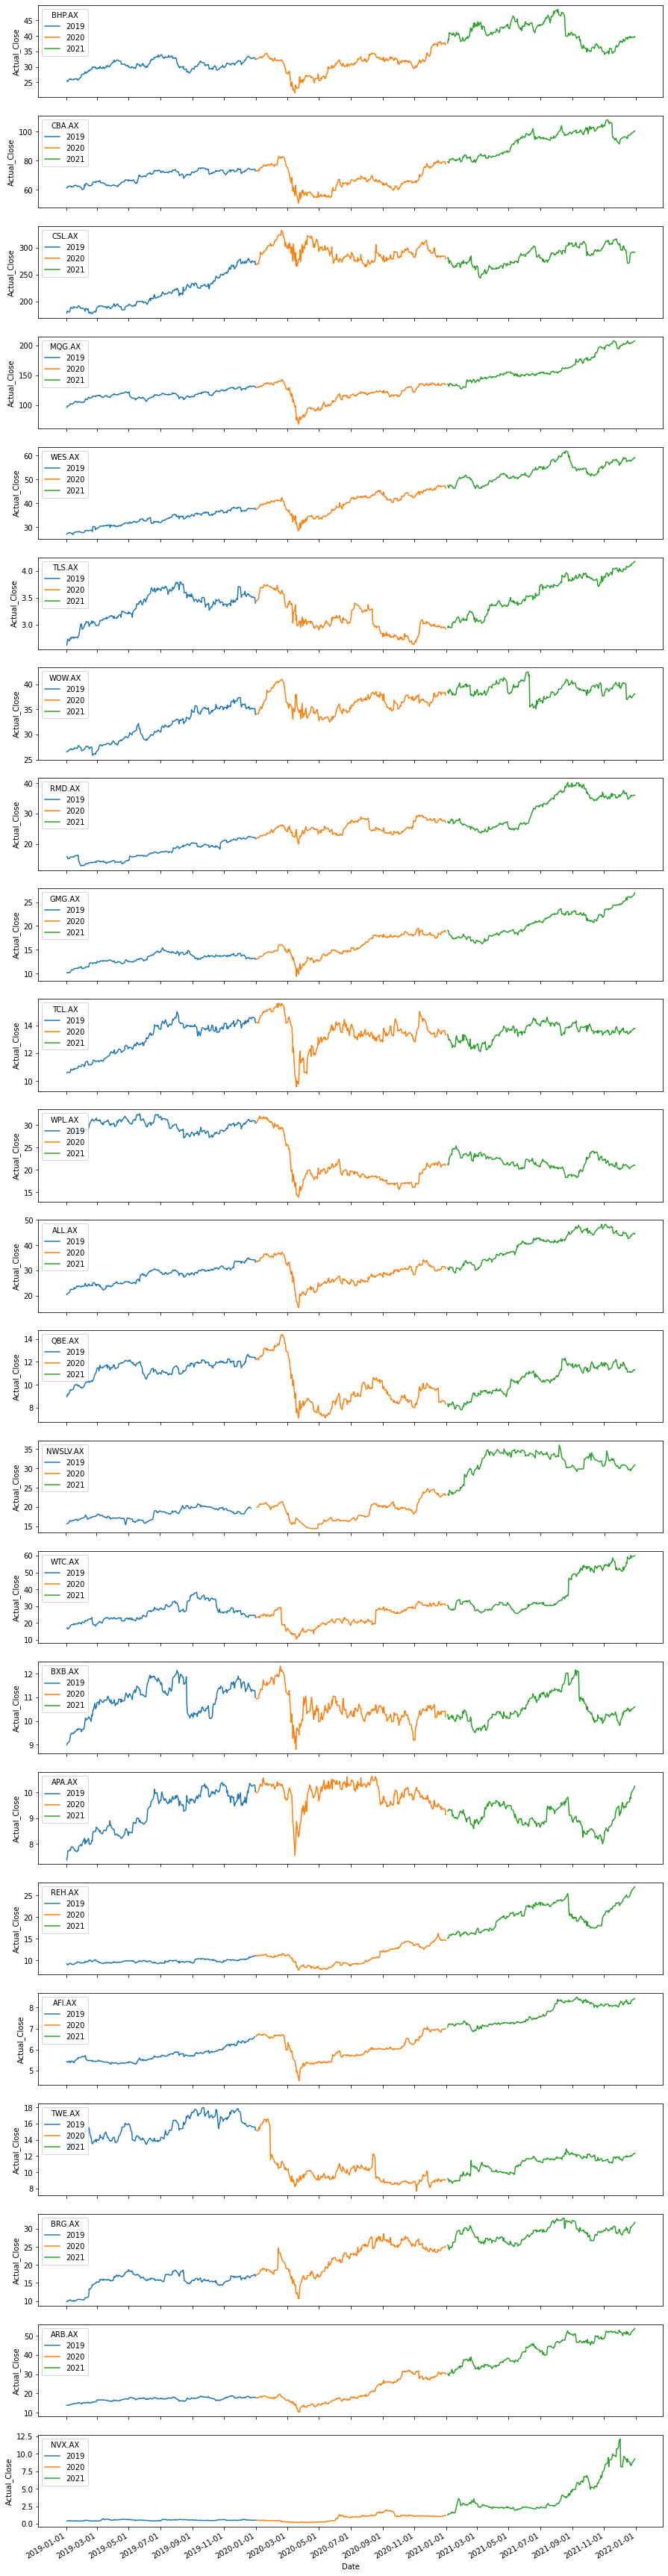

In [12]:
if boolExit == False:
    fig, ax = plt.subplots(nrows=len(GICsGroups), ncols =1, figsize=(15,len(GICsGroups)*3))
    for GICsID in GICsGroups:
        for year, priceDataYearDf in priceDataDict.items():
                #Limit the companies to Top companies in each sector for demo purpose
                filterDf = priceDataYearDf.loc[(priceDataYearDf['GICsID']==GICsID) \
                                                       & (priceDataYearDf['GICsCount']==0)]
                x =filterDf['Date']
                y = filterDf['Actual_Close']
                ax[GICsID].plot(x,y,label=year)

        axTitle = filterDf['code'].iloc[0]
        ax[GICsID].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax[GICsID].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax[GICsID].set_ylabel('Actual_Close') 
        ax[GICsID].legend(title=axTitle, loc='upper left')

    ax[-1].set_xlabel('Date') 
    fig.autofmt_xdate()

## Calculate Mean, Median and Standard Deviation Per year for each company
Calculate Mean, Medium and Standard Deviation for each company per year

In [13]:
pricePivotDf= priceDataDf.pivot_table(
        values='Actual_Close', 
        index='code', 
        columns= 'Year',
        aggfunc= [np.mean, np.median, np.std]).reset_index()
pricestackDfs = []
for statType in ['mean','median','std']:
    pricestackDf = pricePivotDf[['code','mean']].copy()
    pricestackDf.columns = [t[0] if str(t[1]).strip()=='' else t[1]   for t in pricestackDf.columns]
    pricestackDf['statType'] = statType    
    pricestackDfs.append(pricestackDf) 

pricestackedDf=pd.merge(pd.concat(pricestackDfs),asxDf[['code','rank','GICsID','GICsCount']],on='code')
pricestackedDf.sort_values(['rank','statType'],inplace=True)
pricestackedDf.reset_index(drop=True, inplace=True)
pricestackedDf[['code','rank','GICsID','GICsCount','statType']+[year for year in years]]

,code,rank,GICsID,GICsCount,statType,2019,2020,2021
0,BHP.AX,0,0,0,mean,30.449091,31.119529,40.913241
1,BHP.AX,0,0,0,median,30.449091,31.119529,40.913241
2,BHP.AX,0,0,0,std,30.449091,31.119529,40.913241
3,CBA.AX,1,1,0,mean,69.098498,66.957373,93.037075
4,CBA.AX,1,1,0,median,69.098498,66.957373,93.037075
...,...,...,...,...,...,...,...,...
595,GUD.AX,198,21,1,median,9.780988,10.339409,11.370952
596,GUD.AX,198,21,1,std,9.780988,10.339409,11.370952
597,SMR.AX,199,10,13,mean,1.106418,0.789321,0.827391
598,SMR.AX,199,10,13,median,1.106418,0.789321,0.827391


## Visualise the medium close prices for top companies in each sector
As you can see from below chart the share prices were not hugely impacted in 2020.
Prices for most companies have recovered and improved in 2021.
This is a good news that means market has recovered from effects of pandemic

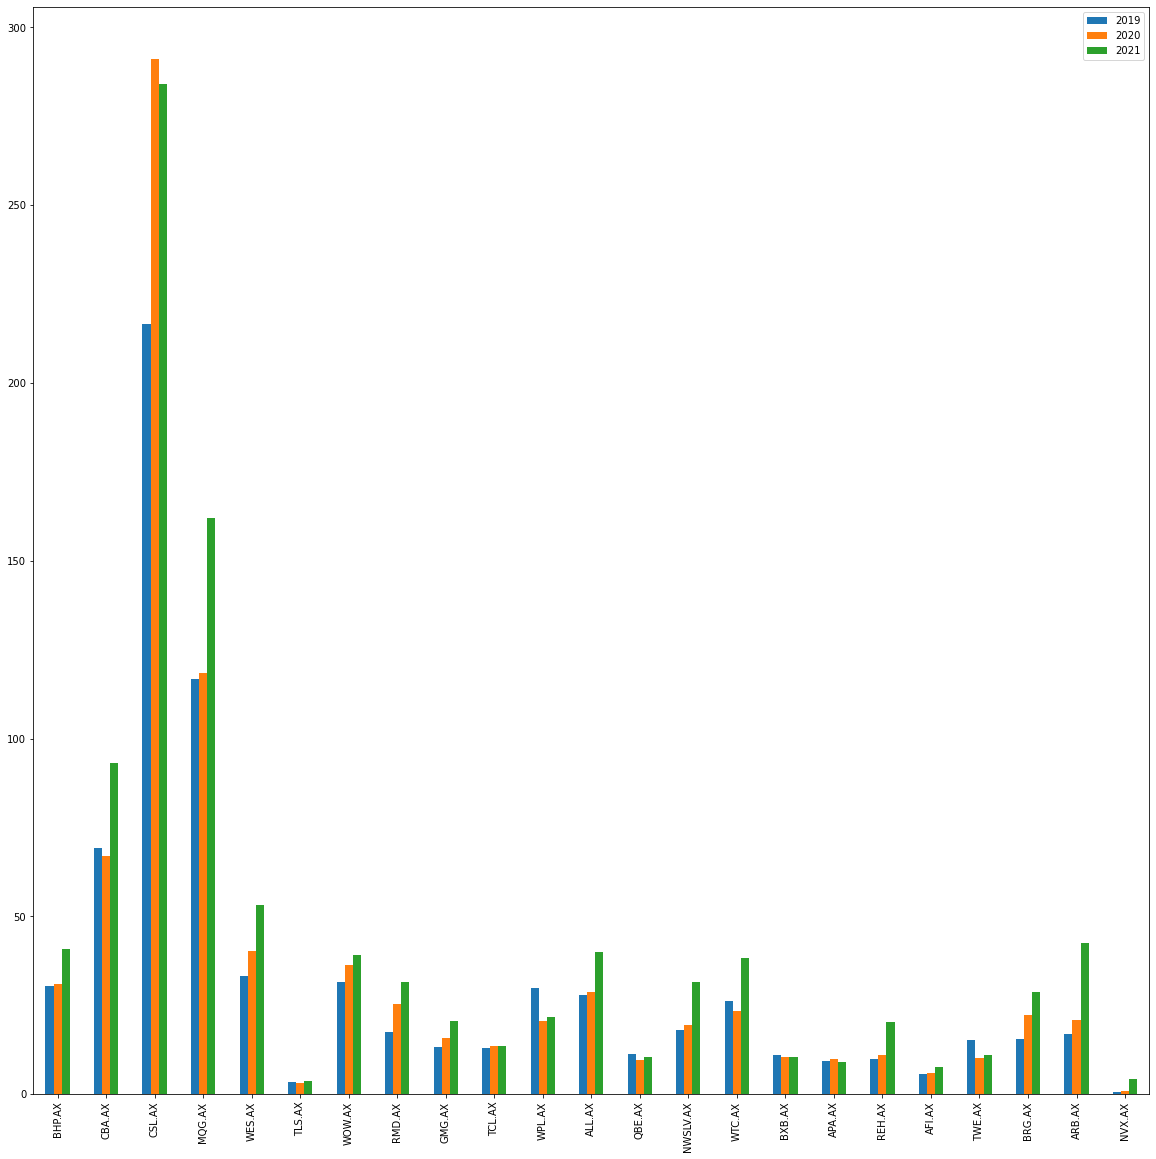

In [14]:
#Limit the companies to Top companies in each sector for demo
filterstackedDf =  pricestackedDf.loc[(pricestackedDf['GICsCount']==0) & (pricestackedDf['statType']=='median')]
cols = ['code','statType'] +[year for year in years]                                       
ax = filterstackedDf[['code','statType'] +[year for year in years]].plot(kind='bar',figsize=(20,20))
ax.set_xticklabels(filterstackedDf['code']);